* Сеть LSTM имеет память, способную запоминать длинные последовательности.

* Обычно состояние в сети сбрасывается после каждого бэтча при обучении модели, а также при каждом вызове model.predict () или model.evaluate (). 

* Мы можем получить контроль над тем, когда внутреннее состояние сети LSTM сбрасывается и сохранять это состояние между бэтчами

* Для этого 1) выставляем stateful = True

* 2) Задаем цикл обучения по эпохам с ручным сбросом состояния в конце каждой эпохи

* Наконец, мы рассмотрим одно из больших преимуществ LSTM - они могут быть объединены в глубокие сетевые архитектуры. 

* LSTM перед каждым последующим уровнем LSTM должен возвращать последовательность. Это можно сделать, установив для параметра возврата последовательностей return_sequences на слое значение True. 

* Мы можем расширить LSTM с сохранением состояния в предыдущем слое

In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [3]:
numpy.random.seed(7)

In [4]:
data_raw = read_csv('airline_dataset.csv', usecols=[1], engine='python', skipfooter=3)

data = data_raw.values.astype("float32")

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

In [6]:
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]

========================================================================================================================

In [7]:
look_back = 3
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [8]:
#[samples, time steps, features]
X_train = numpy.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = numpy.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:
X_train[:3]

array([[[0.01544401],
        [0.02702703],
        [0.05405405]],

       [[0.02702703],
        [0.05405405],
        [0.04826255]],

       [[0.05405405],
        [0.04826255],
        [0.03281853]]], dtype=float32)

In [10]:
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(X_train, Y_train, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 8s - loss: 0.0057
Epoch 1/1
 - 2s - loss: 0.0142
Epoch 1/1
 - 2s - loss: 0.0100
Epoch 1/1
 - 2s - loss: 0.0072
Epoch 1/1
 - 2s - loss: 0.0060
Epoch 1/1
 - 3s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0055
Epoch 1/1
 - 1s - loss: 0.0055
Epoch 1/1
 - 2s - loss: 0.0055
Epoch 1/1
 - 2s - loss: 0.0055
Epoch 1/1
 -

In [11]:
pred_train = model.predict(X_train, batch_size=batch_size)
model.reset_states()
pred_test = model.predict(X_test, batch_size=batch_size)

In [12]:
pred_train = scaler.inverse_transform(pred_train)
Y_train = scaler.inverse_transform([Y_train])
pred_test = scaler.inverse_transform(pred_test)
Y_test = scaler.inverse_transform([Y_test])

In [13]:
score_train = math.sqrt(mean_squared_error(Y_train[0], pred_train[:,0]))
print('Train Score: %.2f RMSE' % (score_train))
score_test = math.sqrt(mean_squared_error(Y_test[0], pred_test[:,0]))
print('Test Score: %.2f RMSE' % (score_test))

Train Score: 29.87 RMSE
Test Score: 79.31 RMSE


In [14]:
pred_train_plot = numpy.empty_like(data)
pred_train_plot[:, :] = numpy.nan
pred_train_plot[look_back:len(pred_train)+look_back, :] = pred_train

pred_test_plot = numpy.empty_like(data)
pred_test_plot[:, :] = numpy.nan
pred_test_plot[len(pred_train)+(look_back*2)+1:len(data)-1, :] = pred_test

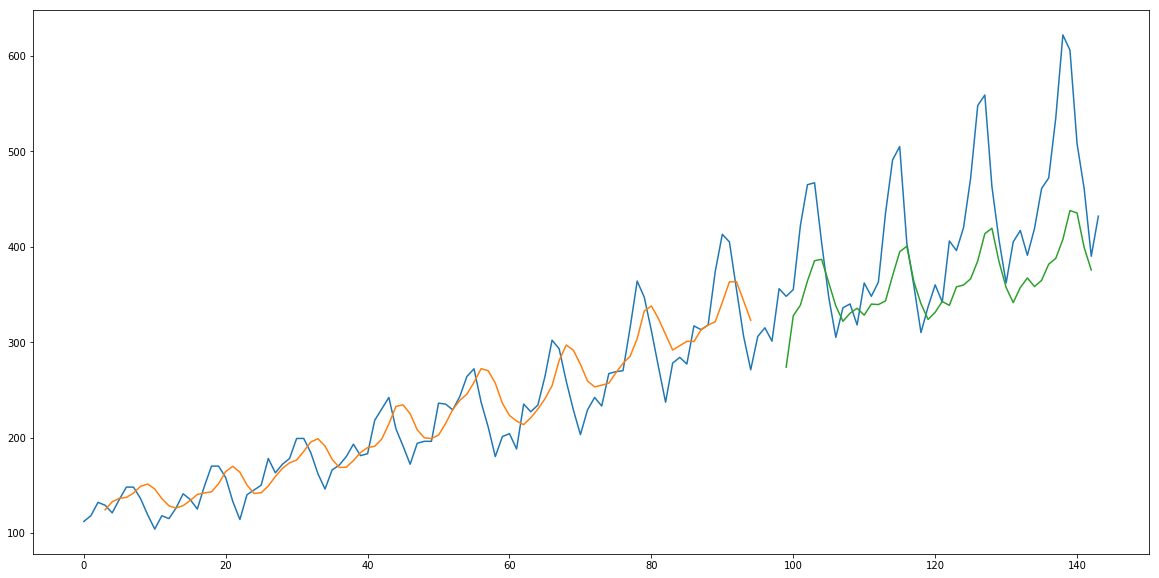

In [15]:
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(data))
plt.plot(pred_train_plot)
plt.plot(pred_test_plot)
plt.show()

Результаты получаются хуже, что наводит на мысль об увеличении количества эпох обучения

========================================================================================================================

In [16]:
look_back = 3
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [17]:
#[samples, time steps, features]
X_train = numpy.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = numpy.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [18]:
X_train[:3]

array([[[0.01544401],
        [0.02702703],
        [0.05405405]],

       [[0.02702703],
        [0.05405405],
        [0.04826255]],

       [[0.05405405],
        [0.04826255],
        [0.03281853]]], dtype=float32)

In [19]:
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(200):
    model.fit(X_train, Y_train, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()

Epoch 1/1
 - 3s - loss: 0.0052
Epoch 1/1
 - 1s - loss: 0.0136
Epoch 1/1
 - 2s - loss: 0.0089
Epoch 1/1
 - 2s - loss: 0.0068
Epoch 1/1
 - 2s - loss: 0.0061
Epoch 1/1
 - 2s - loss: 0.0059
Epoch 1/1
 - 2s - loss: 0.0059
Epoch 1/1
 - 1s - loss: 0.0059
Epoch 1/1
 - 2s - loss: 0.0059
Epoch 1/1
 - 2s - loss: 0.0058
Epoch 1/1
 - 1s - loss: 0.0058
Epoch 1/1
 - 2s - loss: 0.0058
Epoch 1/1
 - 1s - loss: 0.0058
Epoch 1/1
 - 1s - loss: 0.0058
Epoch 1/1
 - 2s - loss: 0.0058
Epoch 1/1
 - 1s - loss: 0.0058
Epoch 1/1
 - 1s - loss: 0.0057
Epoch 1/1
 - 1s - loss: 0.0057
Epoch 1/1
 - 1s - loss: 0.0057
Epoch 1/1
 - 1s - loss: 0.0057
Epoch 1/1
 - 2s - loss: 0.0057
Epoch 1/1
 - 1s - loss: 0.0057
Epoch 1/1
 - 2s - loss: 0.0057
Epoch 1/1
 - 1s - loss: 0.0057
Epoch 1/1
 - 1s - loss: 0.0057
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 1s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/1
 - 2s - loss: 0.0056
Epoch 1/

In [20]:
pred_train = model.predict(X_train, batch_size=batch_size)
model.reset_states()
pred_test = model.predict(X_test, batch_size=batch_size)

In [21]:
pred_train = scaler.inverse_transform(pred_train)
Y_train = scaler.inverse_transform([Y_train])
pred_test = scaler.inverse_transform(pred_test)
Y_test = scaler.inverse_transform([Y_test])

In [22]:
score_train = math.sqrt(mean_squared_error(Y_train[0], pred_train[:,0]))
print('Train Score: %.2f RMSE' % (score_train))
score_test = math.sqrt(mean_squared_error(Y_test[0], pred_test[:,0]))
print('Test Score: %.2f RMSE' % (score_test))

Train Score: 19.85 RMSE
Test Score: 67.61 RMSE


In [23]:
pred_train_plot = numpy.empty_like(data)
pred_train_plot[:, :] = numpy.nan
pred_train_plot[look_back:len(pred_train)+look_back, :] = pred_train

pred_test_plot = numpy.empty_like(data)
pred_test_plot[:, :] = numpy.nan
pred_test_plot[len(pred_train)+(look_back*2)+1:len(data)-1, :] = pred_test

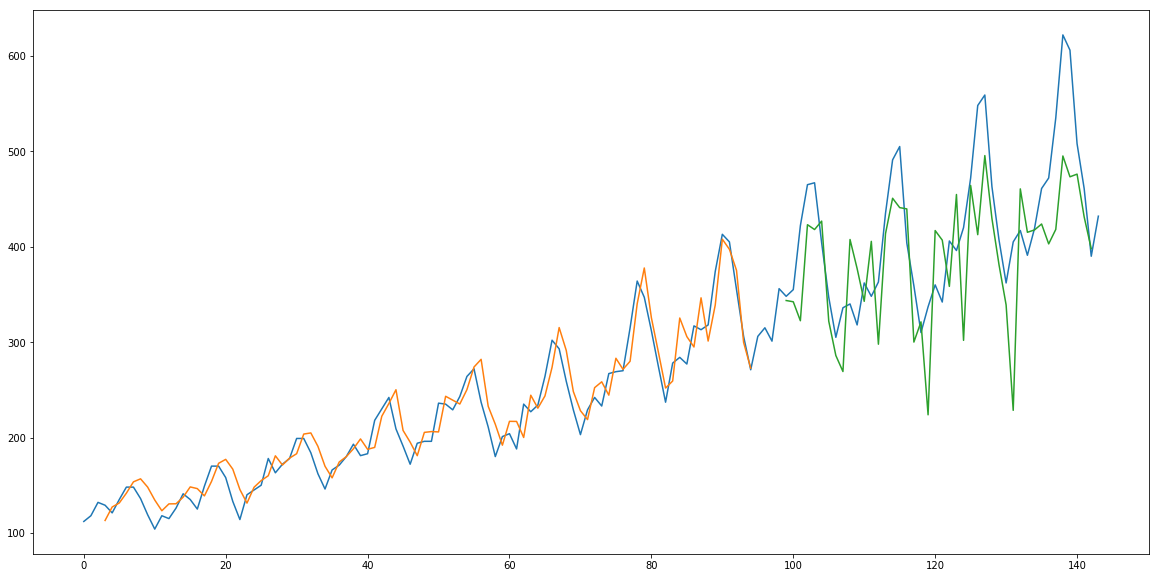

In [24]:
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(data))
plt.plot(pred_train_plot)
plt.plot(pred_test_plot)
plt.show()